<a href="https://colab.research.google.com/github/kpetridis24/computational-intelligence/blob/main/digit_recognition_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Digit Recognition with MLP Neural Network

In [1]:
# %pip install -q -U keras-tuner
# %pip install --upgrade pip
# %pip install tensorflow
# %pip install cm-super 
# %pip install latex 
# %pip install texlive texlive-latex-extra texlive-fonts-recommended dvipng 
# %pip install seaborn
# %pip install matplotlib
# %pip install sklearn
# %pip install numpy

Import useful modules

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
device_name = tf.test.gpu_device_name()
import keras_tuner as kt

Load the dataset

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Reshape the input data so that it fits in the input layer appropriately

In [4]:
X_train = X_train.reshape(len(X_train), 28 * 28)
X_test = X_test.reshape(len(X_test), 28 * 28)

X_train = X_train / 255
X_test = X_test / 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

MLP using **RMSProp** optimizer



In [5]:
histories = {0.01: None, 0.99: None}

for rho in [0.01, 0.99]:
    model = keras.Sequential([
        keras.layers.Dense(126, input_shape=(784,), activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=rho),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    batch_size = 256

    with tf.device('/device:GPU:0'):
        his = model.fit(
            X_train, 
            y_train, 
            epochs=100, 
            batch_size=batch_size, 
            validation_data=(X_val, y_val), 
            verbose=0
        )

        histories[rho] = his

Plot the **Accuracy** and **Loss** of the model

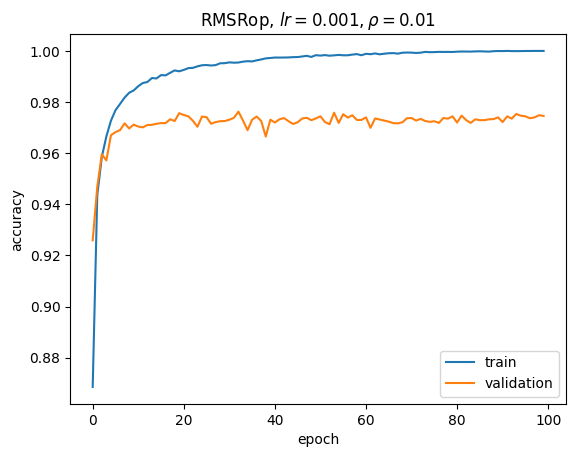

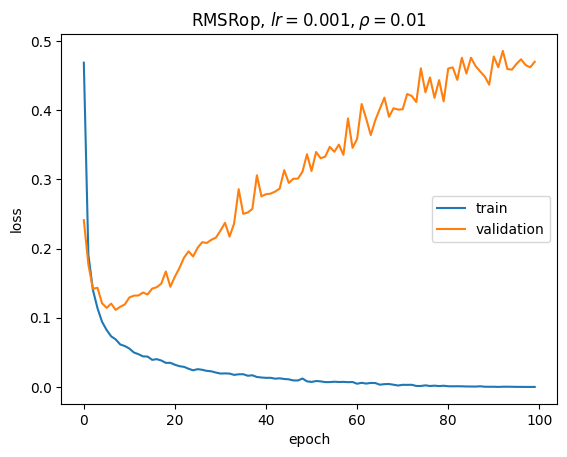

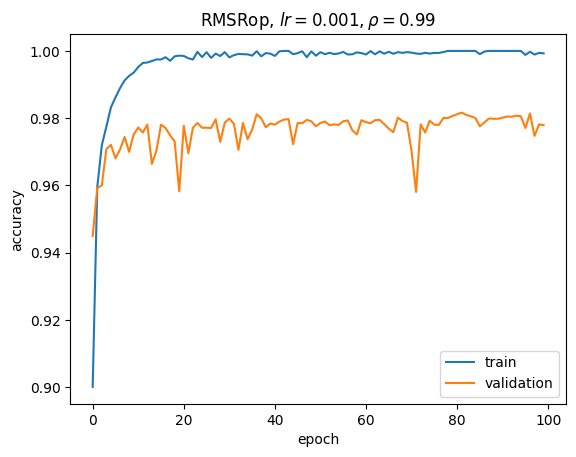

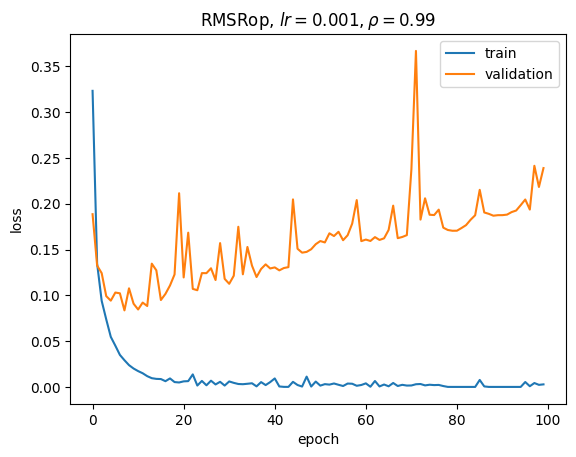

In [6]:
plt.rcParams['text.usetex'] = False

for rho, his in histories.items():
    # Accuracy plot
    plt.plot(his.history["accuracy"])
    plt.plot(his.history["val_accuracy"])
    plt.title(f'RMSRop, $lr=0.001, \\rho={rho}$')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

    # Cost plot
    plt.plot(his.history["loss"])
    plt.plot(his.history["val_loss"])
    plt.title(f'RMSRop, $lr=0.001, \\rho={rho}$')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

Use **L1 and L2 Regularization**

In [7]:
histories = {
    0.01: {
        "L1": {
            0.1: None,
            0.01: None,
            0.001: None
        },
        "L2": {
            0.1: None,
            0.01: None,
            0.001: None
        },
    },
    0.99: {
        "L1": {
            0.1: None,
            0.01: None,
            0.001: None
        },
        "L2": {
            0.1: None,
            0.01: None,
            0.001: None
        },
    }
}

with tf.device('/device:GPU:0'):
    for rho in [0.01, 0.99]:
        for alpha in [0.1, 0.01, 0.001]:
            for regularizer in [
                keras.regularizers.L1(alpha), 
                keras.regularizers.L2(alpha)
            ]:
                model = keras.Sequential([
                    keras.layers.Dense(
                        126, 
                        input_shape=(784,), 
                        activation="relu", 
                        kernel_regularizer=regularizer
                    ),
                    keras.layers.Dense(
                        256, 
                        activation="relu", 
                        kernel_regularizer=regularizer
                    ),
                    keras.layers.Dense(
                        10, 
                        activation="softmax", 
                        kernel_regularizer=regularizer
                    ),
                ])

                model.compile(
                    optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=rho),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"]
                )

                his = model.fit(
                    X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=256, 
                    validation_data=(X_val, y_val), 
                    verbose=0
                )

                reg = str(regularizer).split(".")[2].split(" ")[0]
                histories[rho][reg][alpha] = his

Plot **Accuracy** and **Loss** for all parameters (L1, L2, $\alpha, \rho$)

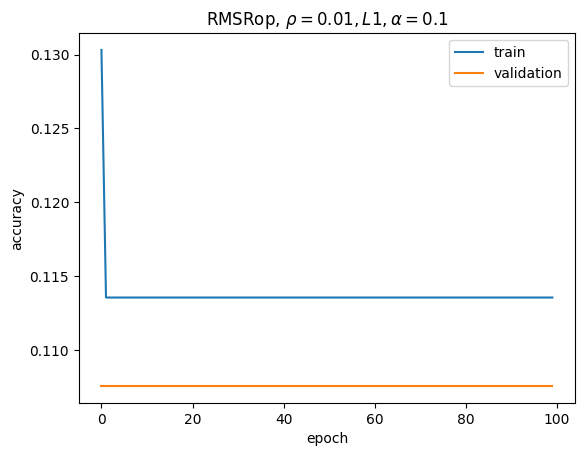

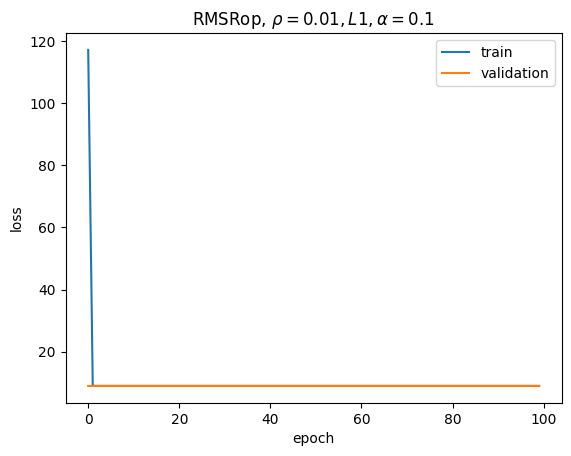

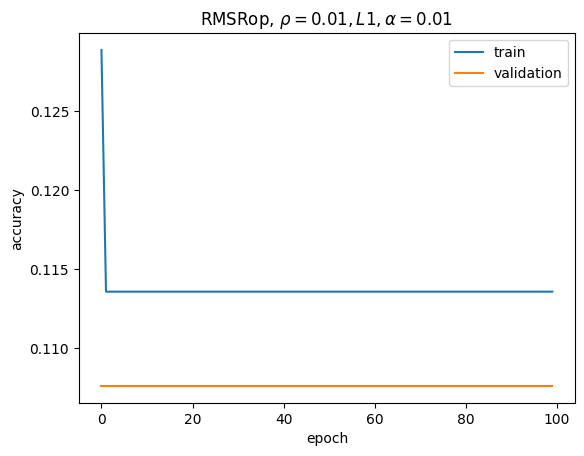

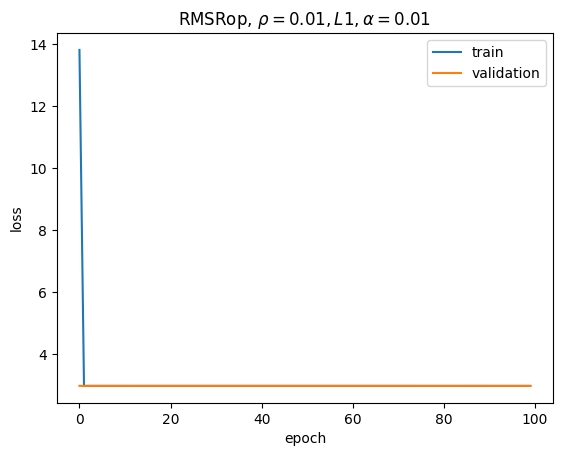

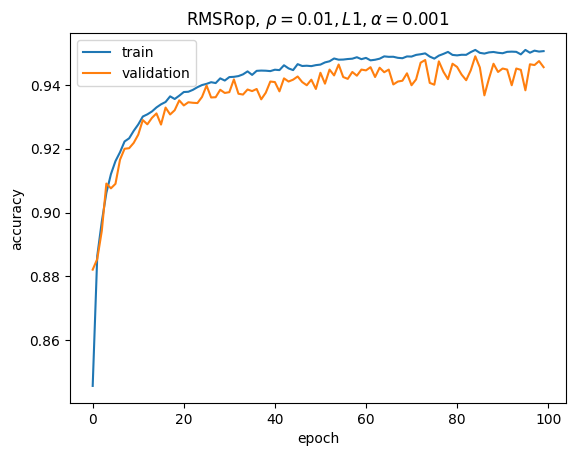

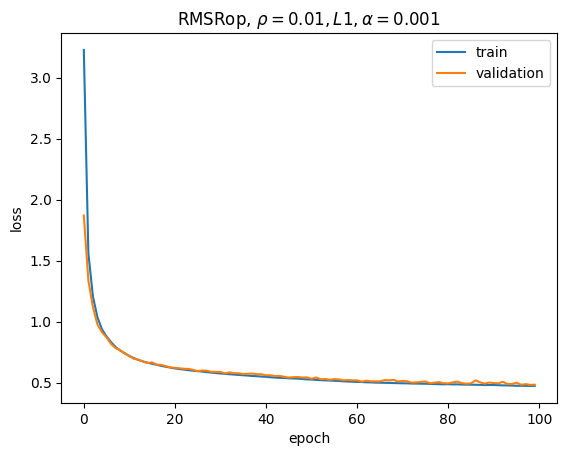

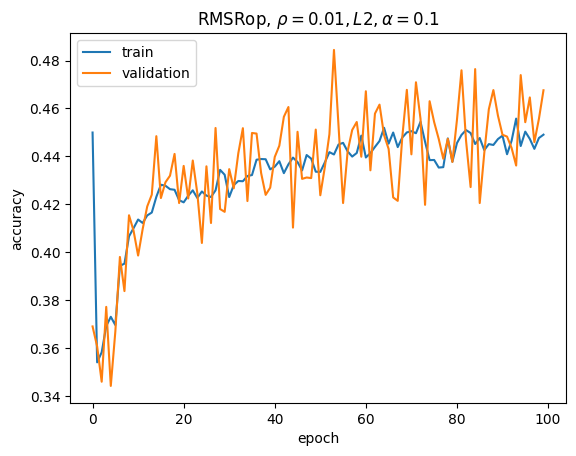

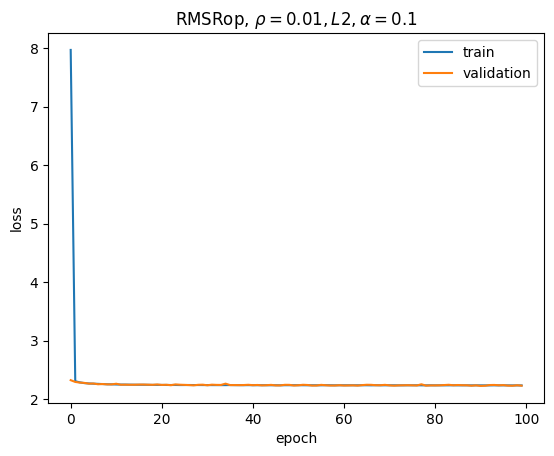

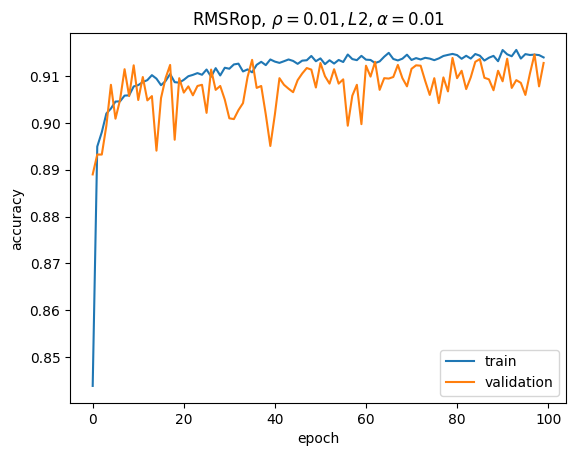

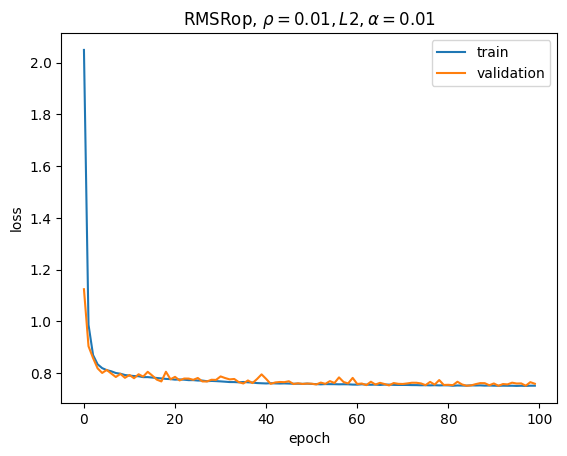

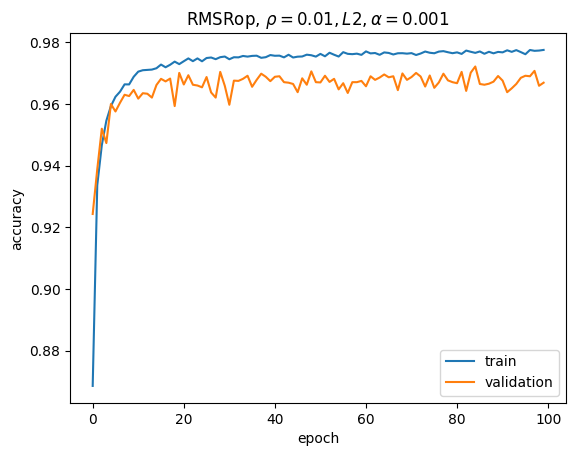

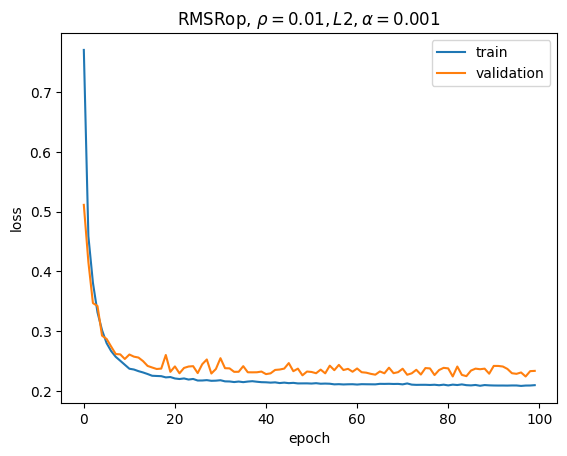

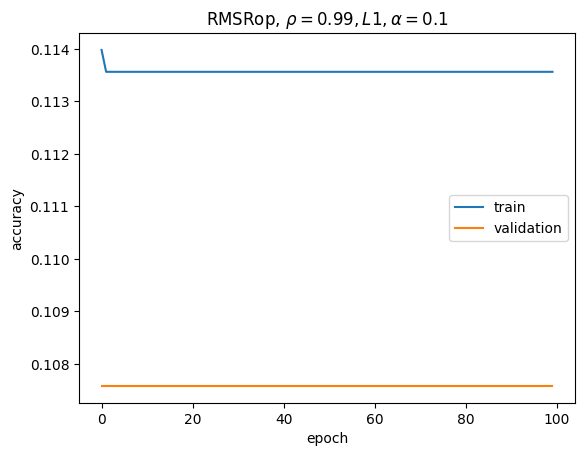

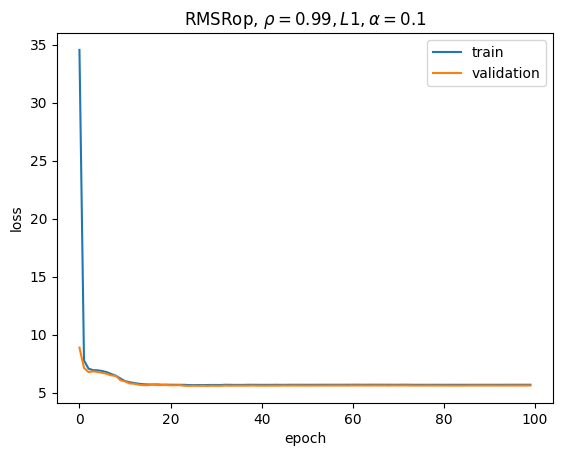

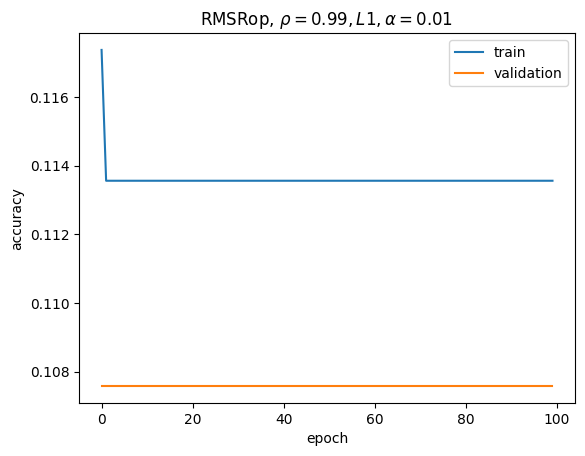

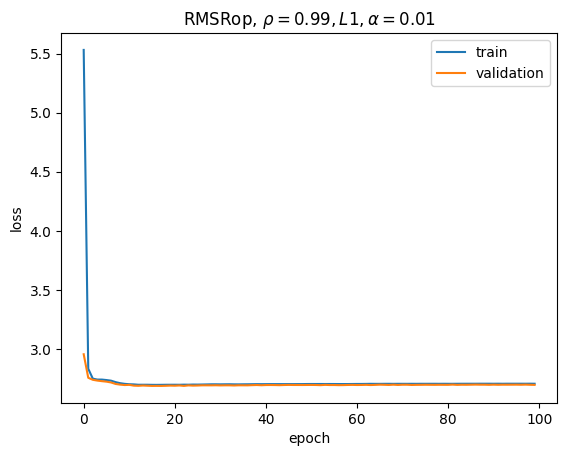

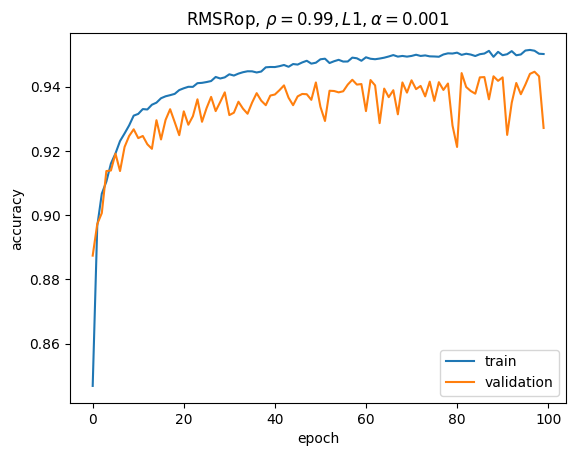

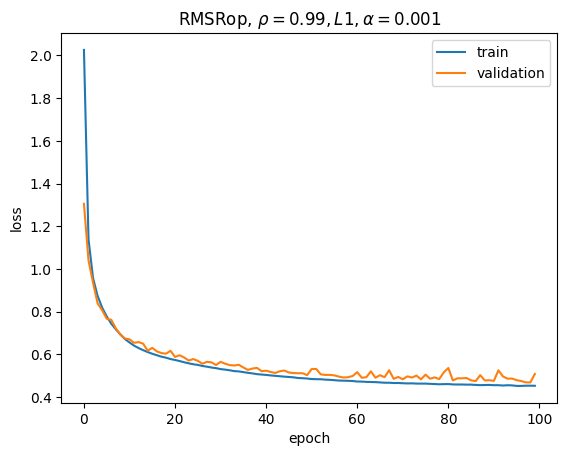

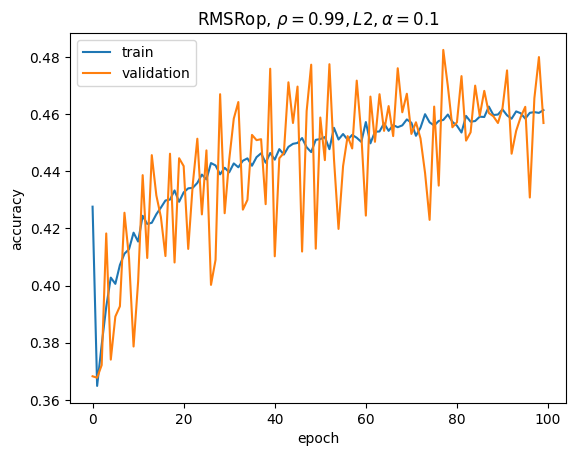

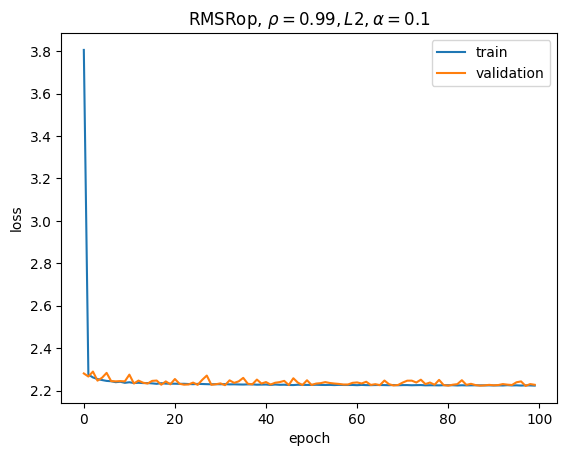

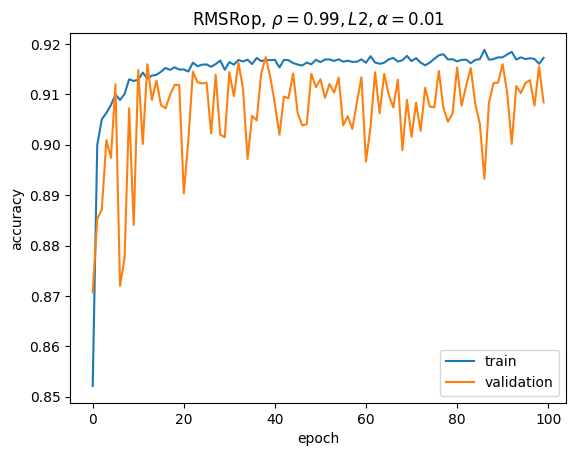

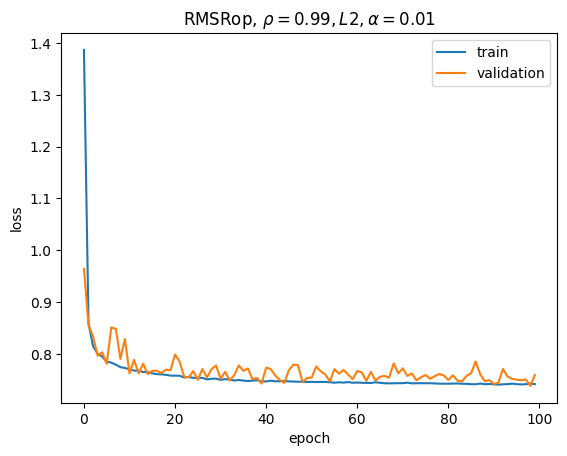

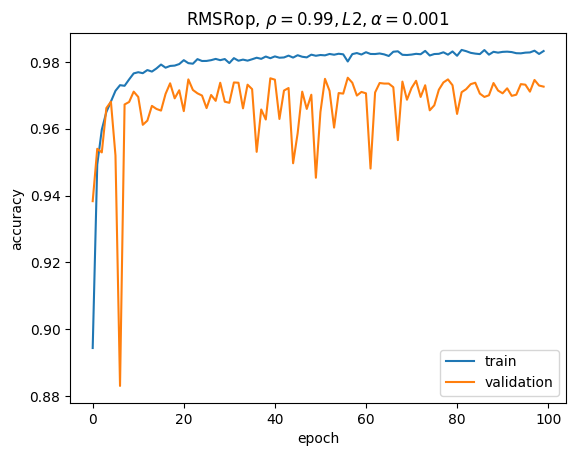

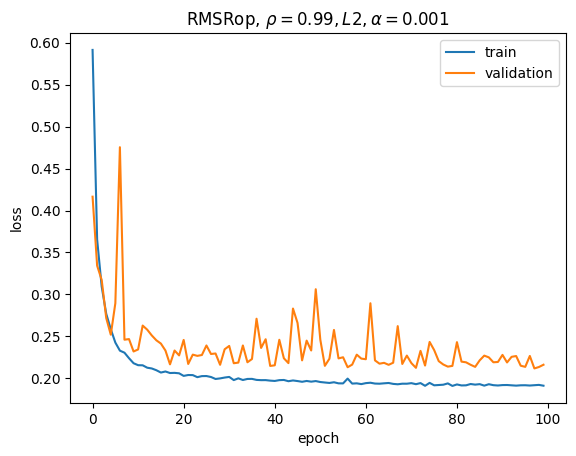

In [8]:
for rho, params in histories.items():
    for regularizer, data in params.items():
        for alpha, his in data.items():
            # Accuracy plot
            plt.plot(his.history["accuracy"])
            plt.plot(his.history["val_accuracy"])
            plt.title(f'RMSRop, $\\rho={rho}, {regularizer}, \\alpha={alpha}$')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'])
            plt.show()

            # Cost plot
            plt.plot(his.history["loss"])
            plt.plot(his.history["val_loss"])
            plt.title(f'RMSRop, $\\rho={rho}, {regularizer}, \\alpha={alpha}$')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'])
            plt.show()

**Fine Tuning** using Keras Tuner

In [9]:
def build_model(hp):
    hp_units1 = hp.Choice('units1', values=[64, 128])
    hp_units2 = hp.Choice('units2', values=[256, 512])
    hp_learning_rate = hp.Choice('learning rate', values=[1e-1, 1e-2, 1e-3])
    hp_a = hp.Choice('coef', values=[1e-1, 1e-3, 1e-6])

    model = keras.Sequential([
        keras.layers.Dense(
            hp_units1, 
            input_shape=(784,), 
            activation="relu", 
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.L2(hp_a)
        ),
        keras.layers.Dense(
            hp_units2, 
            activation="relu", 
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.L2(hp_a)
        ),
        keras.layers.Dense(
            10, 
            activation="softmax", 
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.L2(hp_a)
        ),
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(
            learning_rate=hp_learning_rate, 
            rho=0.9
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [10]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    overwrite=True
)

stop_early = keras.callbacks.EarlyStopping(monitor='loss', patience=200)

tuner.search(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_val, y_val), 
    callbacks=[stop_early]
)

Trial 20 Complete [00h 23m 58s]
val_loss: 2.223684310913086

Best val_loss So Far: 2.222181558609009
Total elapsed time: 06h 31m 15s
INFO:tensorflow:Oracle triggered exit


Get the best RBF model

In [11]:
best_model = tuner.get_best_models()[0]
best_hs = tuner.get_best_hyperparameters()[0]
best_model.summary()

n1_optimal = best_hs.get("units1")
n2_optimal = best_hs.get("units2")
alpha_optimal = best_hs.get("coef")
lr_optimal = best_hs.get("learning rate")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 512)               33280     
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 88,650
Trainable params: 88,650
Non-trainable params: 0
_________________________________________________________________


Train and analyze the best model

In [12]:
regularizer = tf.keras.regularizers.l2(alpha_optimal)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_optimal)

optimal_model = keras.Sequential([
    keras.layers.Dense(
        n1_optimal, 
        input_shape=(784,), 
        activation="relu", 
        kernel_regularizer=regularizer, 
        kernel_initializer=tf.keras.initializers.HeNormal()
    ),
    keras.layers.Dense(
        n2_optimal,
        activation="relu"
    ),
    keras.layers.Dense(
        10, 
        activation="softmax"
    )
])

optimal_model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = optimal_model.fit(
    X_train, 
    y_train, 
    batch_size=256, 
    epochs=100, 
    validation_data=(X_val, y_val),
    verbose=0
)

313/313 [==============================] - 1s 3ms/step


Text(95.72222222222221, 0.5, 'True')

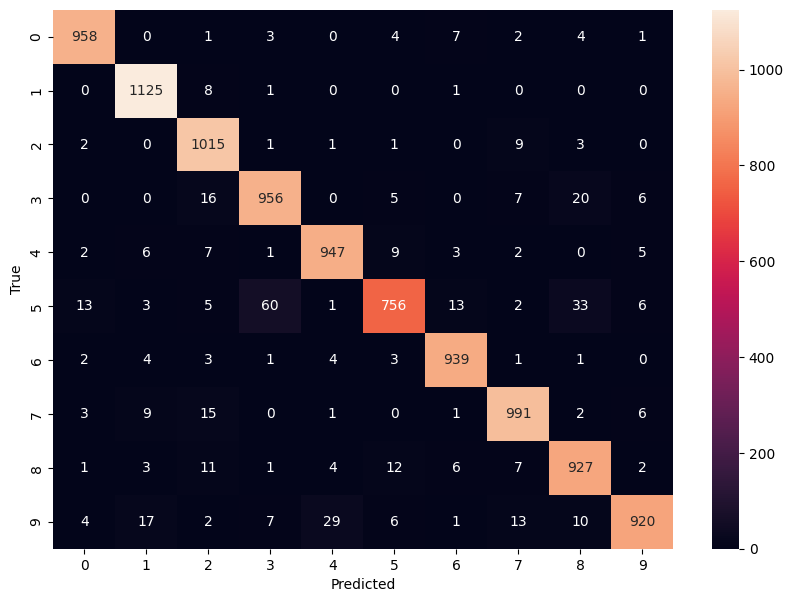

In [13]:
y_pred = optimal_model.predict(X_test)
y_pred_labels = [np.argmax(pred) for pred in y_pred]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_labels)

plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")

Compute **TP, TN, FP, FN**

TN = 89534 
FP = 466 
FN = 466 
TP = 9534 
SUM = 100000
Accuracy = 0.99068 
Recall = 0.9534 
Precision = 0.9534 
F1 = 0.9534


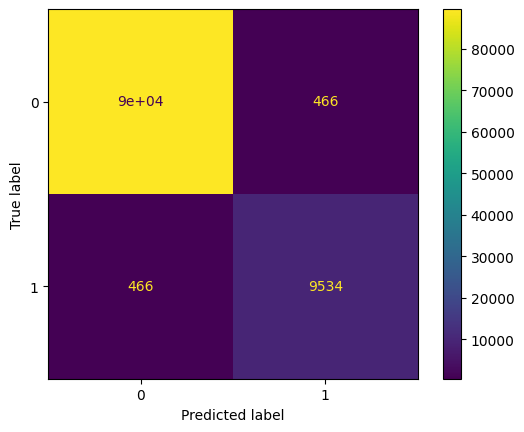

In [14]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

multilabel_cm = multilabel_confusion_matrix(y_test, y_pred_labels)
confusion_matrix_ = np.sum(multilabel_cm, axis = 0)
ConfusionMatrixDisplay(confusion_matrix_).plot()

tn = confusion_matrix_[0][0]
fp = confusion_matrix_[0][1]
fn = confusion_matrix_[1][0]
tp = confusion_matrix_[1][1]
sum = tn + fp + fn + tp

print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp, "\nSUM =", sum)

accuracy = (tp + tn) / sum
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print("Accuracy =", accuracy, "\nRecall =", recall, "\nPrecision =", precision, "\nF1 =", f1)

Plot **Accuracy and Loss** in training and validation set during training

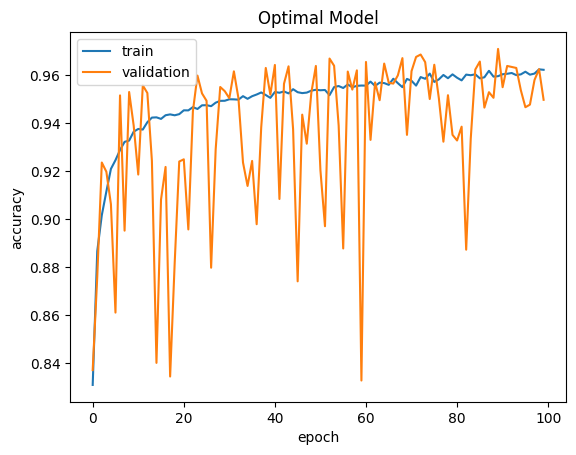

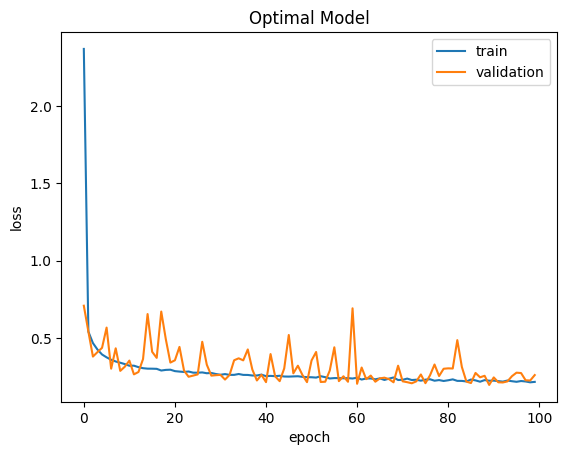

In [15]:
# Accuracy plot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title(f'Optimal Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# Cost plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title(f'Optimal Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred_labels, average="weighted")

0.9530428295380571